In [55]:
# import warnings
# warnings.filterwarnings('ignore')

import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xg
import joblib

# Technical Analysis
from talib import RSI, BBANDS, ATR, NATR, MACD

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# neural network
from tqdm import tqdm
import torch
import torch.nn as nn
  # our model
from LSTM import LSTM

# Data Preprocessing

In [56]:
# def read_tickers_sp500(file_path):
#     with open(file_path, 'r') as file:
#         tickers_sp500 = [line.strip() for line in file]
#     return tickers_sp500

# tickers_sp500 = read_tickers_sp500('tickers_sp500.txt')
# print(tickers_sp500)

In [76]:
# Download data

# Stocks list
# top 7 MarketCap in S&P500(^GSPC)
# tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META', 'AMD', 'INTC', 'NFLX', 'PYPL', 'ASML']
# tickers = tickers_sp500
start_date = '2014-05-01'
end_date = '2024-05-01'

df_prices_download = yf.download(tickers=tickers, start=start_date, end=end_date, group_by='ticker')

[*********************100%%**********************]  13 of 13 completed


In [77]:
# Format into large table
# col: OHLCV
# rows(multi-index): Ticker, Date

df_prices = df_prices_download.stack(level=0, dropna=False)
df_prices = df_prices.swaplevel(0, 1)
df_prices = df_prices.loc[tickers].sort_index(level='Ticker')
df_prices.dropna(inplace=True)

# Use 'Adj Close' instead of 'Close'
df_prices.drop('Close', axis=1, inplace=True)
df_prices.rename(columns={'Adj Close': 'Close'}, inplace=True)

df_prices

Price                     Open         High          Low        Close  \
Ticker Date                                                             
AAPL   2014-05-01    21.142857    21.242857    20.941429    18.581398   
       2014-05-02    21.155001    21.221430    21.061071    18.615952   
       2014-05-05    21.076429    21.464287    21.071428    18.879208   
       2014-05-06    21.492857    21.586071    21.228930    18.673439   
       2014-05-07    21.258928    21.331785    20.990356    18.608095   
...                        ...          ...          ...          ...   
^GSPC  2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883   
       2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922   
       2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961   
       2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922   
       2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941   

Price                    Volume  
Ticker Date                      
AAPL   2014-05-01  2.440480e+08  
       2014-05-02  1.915144e+08  
       2014-05-05  2.870672e+08  
       2014-05-06  3.745644e+08  
       2014-05-07  2.828644e+08  
...                         ...  
^GSPC  2024-04-24  3.656740e+09  
       2024-04-25  3.958050e+09  
       2024-04-26  3.604140e+09  
       2024-04-29  3.447450e+09  
       2024-04-30  4.082470e+09  

[32425 rows x 5 columns]

# Feature Engineering

### RSI - Relative Strength Index
RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold.

In [78]:
rsi = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(RSI)
df_prices['RSI'] = rsi

### Bollinger Bands
Bollinger Bands is a technical analysis tool used to determine where prices are high and low relative to each other.

In [79]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'BB_High': high,
                         'BB_Mid': mid, # SMA20
                         'BB_Low': low},
                        index=close.index)

bbands = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_bb)
df_prices = pd.concat([df_prices, bbands], axis=1)

### ATR - Average True Range
The average true range (ATR) indicator shows the volatility of the market.

In [80]:
by_ticker = df_prices.groupby('Ticker', group_keys=False)

def compute_atr(stock_data):
    atr = ATR(stock_data.High,
              stock_data.Low,
              stock_data.Close,
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

df_prices['ATR'] = by_ticker.apply(compute_atr)
# Normalized Average True Range (NATR)
df_prices['NATR'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

### MACD - Moving Average Convergence/Divergence

In [81]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

df_prices['MACD'] = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_macd)

## Determine Investment Universe

### Dollar Volume

In [82]:
# Close: USD
# Volumn: Amount
df_prices['Dollar_Volume'] = (df_prices.loc[:, 'Close']
                           .mul(df_prices.loc[:, 'Volume'], axis=0))

df_prices.Dollar_Volume /= 1e6 # Dollar_Volume: Million USD

df_prices.dropna(inplace=True)

In [83]:
remian_cols = [c for c in df_prices.columns.unique(0) if c not in ['Dollar_Volume', 'Volume']]

# New data frame: 'data' - load to model
data = (
    pd.concat(
        [
        # avg(1M) Dollar_Volume
            df_prices.unstack("Ticker")
            .Dollar_Volume.resample('D')
            .mean()
            .stack("Ticker")
            .to_frame("Dollar_Volume"),
        # (Adj)Close & Technical Indicators
            df_prices.unstack("Ticker")[remian_cols]
            .resample('D')
            .last()
            .stack("Ticker")
        ],
        axis=1
    )
    .swaplevel()
    .sort_index(level='Ticker')
    .dropna()
)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31996 entries, ('AAPL', Timestamp('2014-06-18 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31996 non-null  float64
 1   Open           31996 non-null  float64
 2   High           31996 non-null  float64
 3   Low            31996 non-null  float64
 4   Close          31996 non-null  float64
 5   RSI            31996 non-null  float64
 6   BB_High        31996 non-null  float64
 7   BB_Mid         31996 non-null  float64
 8   BB_Low         31996 non-null  float64
 9   ATR            31996 non-null  float64
 10  NATR           31996 non-null  float64
 11  MACD           31996 non-null  float64
dtypes: float64(12)
memory usage: 3.2+ MB


## Monthly Return

In [84]:
outlier_cutoff = 0.01 # winsorize returns at the [1%, 99%]
# lags = [1, 3, 6, 12] # Month timeframe
lags = [1, 5, 10, 21, 42, 63] # Day timeframe
returns = []

for lag in lags:
    returns.append(data
                   .Close
                   .unstack('Ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('Ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'Return_{lag}d')
                   )

returns.append(data.High.unstack('Ticker').sort_index().pct_change(1).stack('Ticker')
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
               .to_frame("High_Return"))
returns.append(data.Low.unstack('Ticker').sort_index().pct_change(1).stack('Ticker')
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
               .to_frame("Low_Return"))
returns.append(data.Open.unstack('Ticker').sort_index().pct_change(1).stack('Ticker')
               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
               .to_frame("Open_Return"))

df_returns = pd.concat(returns, axis=1).swaplevel().sort_index(level='Ticker')
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31983 entries, ('AAPL', Timestamp('2014-06-19 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Return_1d    31983 non-null  float64
 1   Return_5d    31931 non-null  float64
 2   Return_10d   31866 non-null  float64
 3   Return_21d   31723 non-null  float64
 4   Return_42d   31450 non-null  float64
 5   Return_63d   31177 non-null  float64
 6   High_Return  31983 non-null  float64
 7   Low_Return   31983 non-null  float64
 8   Open_Return  31983 non-null  float64
dtypes: float64(9)
memory usage: 2.3+ MB


In [85]:
# merge returns -> data
# drop 'Close', use 'Returns' instead
data = data.join(df_returns).drop(['Close','High','Low','Open'], axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31177 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31177 non-null  float64
 1   RSI            31177 non-null  float64
 2   BB_High        31177 non-null  float64
 3   BB_Mid         31177 non-null  float64
 4   BB_Low         31177 non-null  float64
 5   ATR            31177 non-null  float64
 6   NATR           31177 non-null  float64
 7   MACD           31177 non-null  float64
 8   Return_1d      31177 non-null  float64
 9   Return_5d      31177 non-null  float64
 10  Return_10d     31177 non-null  float64
 11  Return_21d     31177 non-null  float64
 12  Return_42d     31177 non-null  float64
 13  Return_63d     31177 non-null  float64
 14  High_Return    31177 non-null  float64
 15  Low_Return     31177 non-null  float64
 16  Open_Return    

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31177 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31177 non-null  float64
 1   RSI            31177 non-null  float64
 2   BB_High        31177 non-null  float64
 3   BB_Mid         31177 non-null  float64
 4   BB_Low         31177 non-null  float64
 5   ATR            31177 non-null  float64
 6   NATR           31177 non-null  float64
 7   MACD           31177 non-null  float64
 8   Return_1d      31177 non-null  float64
 9   Return_5d      31177 non-null  float64
 10  Return_10d     31177 non-null  float64
 11  Return_21d     31177 non-null  float64
 12  Return_42d     31177 non-null  float64
 13  Return_63d     31177 non-null  float64
 14  High_Return    31177 non-null  float64
 15  Low_Return     31177 non-null  float64
 16  Open_Return    

## Price Momentum
This factor computes the total return for a given number of prior trading days d.

In [87]:
# # Month timeframe
# for lag in [3, 6, 12]:
#     data[f'Momentum_{lag}'] = data[f'Return_{lag}m'].sub(data.Return_1m) # 3Xm - 1m
#     if lag > 3:
#         data[f'Momentum_3_{lag}'] = data[f'Return_{lag}m'].sub(data.Return_3m) # 6Xm - 3m

# Day timeframe
for lag in [5, 10, 21, 42, 63]:
    data[f'Momentum_{lag}'] = data[f'Return_{lag}d'].sub(data.Return_1d) # 3Xm - 1m
    if lag > 5:
        data[f'Momentum_5_{lag}'] = data[f'Return_{lag}d'].sub(data.Return_5d) # 6Xm - 3m

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31177 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31177 non-null  float64
 1   RSI            31177 non-null  float64
 2   BB_High        31177 non-null  float64
 3   BB_Mid         31177 non-null  float64
 4   BB_Low         31177 non-null  float64
 5   ATR            31177 non-null  float64
 6   NATR           31177 non-null  float64
 7   MACD           31177 non-null  float64
 8   Return_1d      31177 non-null  float64
 9   Return_5d      31177 non-null  float64
 10  Return_10d     31177 non-null  float64
 11  Return_21d     31177 non-null  float64
 12  Return_42d     31177 non-null  float64
 13  Return_63d     31177 non-null  float64
 14  High_Return    31177 non-null  float64
 15  Low_Return     31177 non-null  float64
 16  Open_Return    

## Date Indicators

In [88]:
dates = data.index.get_level_values('Date')
data['Year'] = dates.year
data['Month'] = dates.month

## Target: Holding Period Returns
1 day target holding period\
= to predict return in next 1 day (tomorrow)

In [89]:
data['target'] = data.groupby(level='Ticker')['Return_1d'].shift(-1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31164 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-29 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31164 non-null  float64
 1   RSI            31164 non-null  float64
 2   BB_High        31164 non-null  float64
 3   BB_Mid         31164 non-null  float64
 4   BB_Low         31164 non-null  float64
 5   ATR            31164 non-null  float64
 6   NATR           31164 non-null  float64
 7   MACD           31164 non-null  float64
 8   Return_1d      31164 non-null  float64
 9   Return_5d      31164 non-null  float64
 10  Return_10d     31164 non-null  float64
 11  Return_21d     31164 non-null  float64
 12  Return_42d     31164 non-null  float64
 13  Return_63d     31164 non-null  float64
 14  High_Return    31164 non-null  float64
 15  Low_Return     31164 non-null  float64
 16  Open_Return    

## Save data to local

In [90]:
DATA_PATH = 'data'

df_prices.to_csv(f'{DATA_PATH}/prices.csv', index=True)
df_returns.to_csv(f'{DATA_PATH}/returns.csv', index=True)
data.to_csv(f'{DATA_PATH}/data.csv', index=True)

In [91]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31996 entries, ('AAPL', Timestamp('2014-06-18 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           31996 non-null  float64
 1   High           31996 non-null  float64
 2   Low            31996 non-null  float64
 3   Close          31996 non-null  float64
 4   Volume         31996 non-null  float64
 5   RSI            31996 non-null  float64
 6   BB_High        31996 non-null  float64
 7   BB_Mid         31996 non-null  float64
 8   BB_Low         31996 non-null  float64
 9   ATR            31996 non-null  float64
 10  NATR           31996 non-null  float64
 11  MACD           31996 non-null  float64
 12  Dollar_Volume  31996 non-null  float64
dtypes: float64(13)
memory usage: 3.3+ MB


In [92]:
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31983 entries, ('AAPL', Timestamp('2014-06-19 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Return_1d    31983 non-null  float64
 1   Return_5d    31931 non-null  float64
 2   Return_10d   31866 non-null  float64
 3   Return_21d   31723 non-null  float64
 4   Return_42d   31450 non-null  float64
 5   Return_63d   31177 non-null  float64
 6   High_Return  31983 non-null  float64
 7   Low_Return   31983 non-null  float64
 8   Open_Return  31983 non-null  float64
dtypes: float64(9)
memory usage: 3.4+ MB


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31164 entries, ('AAPL', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-29 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  31164 non-null  float64
 1   RSI            31164 non-null  float64
 2   BB_High        31164 non-null  float64
 3   BB_Mid         31164 non-null  float64
 4   BB_Low         31164 non-null  float64
 5   ATR            31164 non-null  float64
 6   NATR           31164 non-null  float64
 7   MACD           31164 non-null  float64
 8   Return_1d      31164 non-null  float64
 9   Return_5d      31164 non-null  float64
 10  Return_10d     31164 non-null  float64
 11  Return_21d     31164 non-null  float64
 12  Return_42d     31164 non-null  float64
 13  Return_63d     31164 non-null  float64
 14  High_Return    31164 non-null  float64
 15  Low_Return     31164 non-null  float64
 16  Open_Return    

# Scaling Data
**Strategy:** Standard Score (Z-Score)

In [94]:
selected_data = data  #[selected]

norm_cols = selected_data.columns[:-1]  # Excluding Target column

# Create a ColumnTransformer to apply scaling only to specified columns
column_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), norm_cols)
    ],
    remainder='passthrough'  # Keep non-scaled columns unchanged
)

norm_data = column_transformer.fit_transform(selected_data)

print(norm_data)
print(norm_data.shape)

[[-2.65933330e-01  3.99894660e-01 -1.12734833e+00 ... -1.81677484e+00
   7.08631439e-01  2.06775578e-03]
 [-2.66501844e-01  4.64459124e-01 -1.12673464e+00 ... -1.81677484e+00
   7.08631439e-01 -8.15395603e-03]
 [-2.65702951e-01  9.48769238e-02 -1.12661886e+00 ... -1.81677484e+00
   7.08631439e-01  9.90368012e-04]
 ...
 [ 5.07465878e+00 -8.68578201e-01  2.69209547e+00 ...  1.77785721e+00
  -7.26779036e-01  1.02091426e-02]
 [ 4.64665829e+00 -3.49214167e-01  2.68963006e+00 ...  1.77785721e+00
  -7.26779036e-01  3.17844867e-03]
 [ 4.44795947e+00 -1.98862982e-01  2.68730204e+00 ...  1.77785721e+00
  -7.26779036e-01 -1.57305136e-02]]
(31164, 29)


# Model

(Sorry, I haven't implemented naive forecast)

## Train-Test Split
**Strategy:** Simple Split

Split arrays or matrices into random train and test subsets.

In [98]:
X = norm_data[:, :-1]
y = norm_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("Train Set:", X_train.shape, y_train.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (23373, 28) (23373,)
Test Set: (7791, 28) (7791,)


## Train Model

Training models without hyperparameter tuning for improvement comparision.

In [99]:
if torch.cuda.is_available():
    # Nvidia CUDA
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Apple Metal
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: cpu


In [102]:
# naive_model = None
linear_model = LinearRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
xgb_model = xg.XGBRegressor()
# lstm_model = LSTM()

models = {
    # 'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'XGB': xgb_model,
    # 'LSTM': lstm_model
}

In [103]:
results = dict()

for name, model in models.items():
    print(f"Training {name} ...")

    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )

    results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training LinearRegression ...
Training SVR ...
Training RFR ...
Training XGB ...


Model: LinearRegression
MAE: 0.0156
MSE: 0.0005
RMSE: 0.0220
Direction: 0.5224


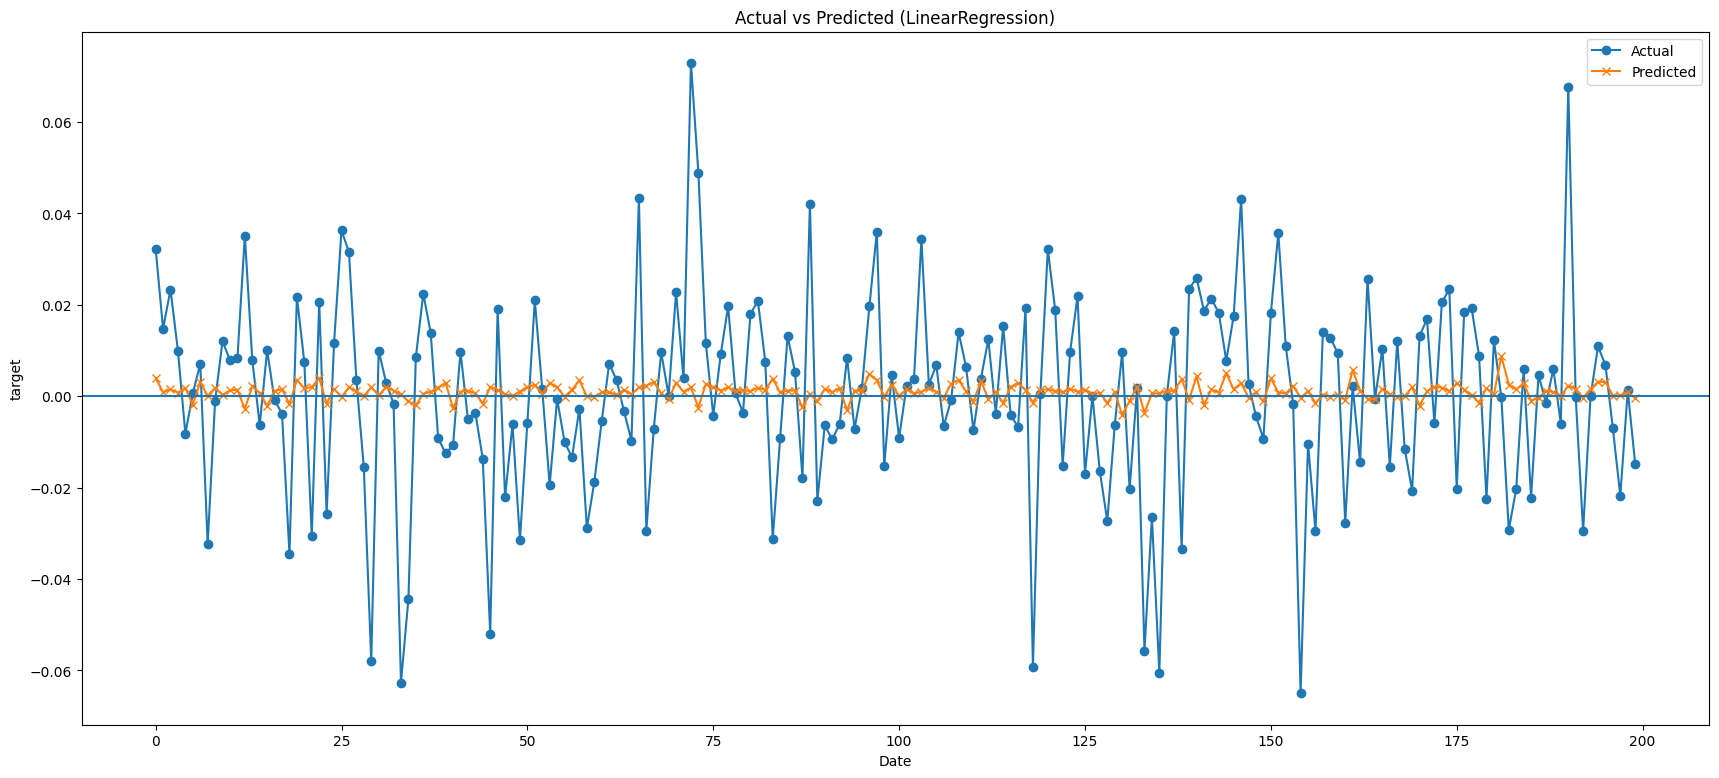

Model: SVR
MAE: 0.0158
MSE: 0.0005
RMSE: 0.0221
Direction: 0.5313


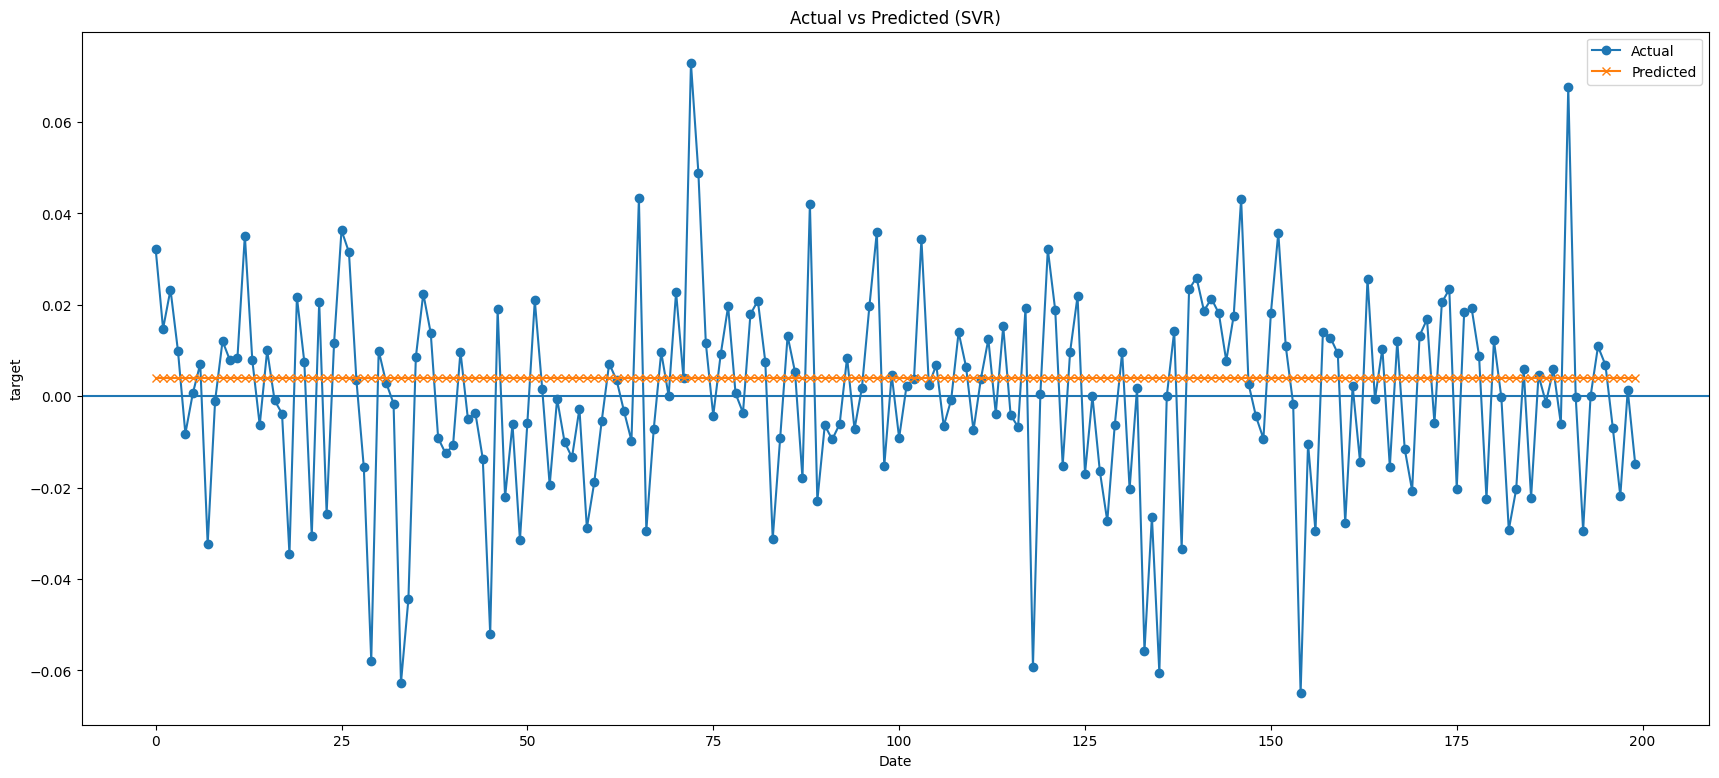

Model: RFR
MAE: 0.0156
MSE: 0.0005
RMSE: 0.0219
Direction: 0.5368


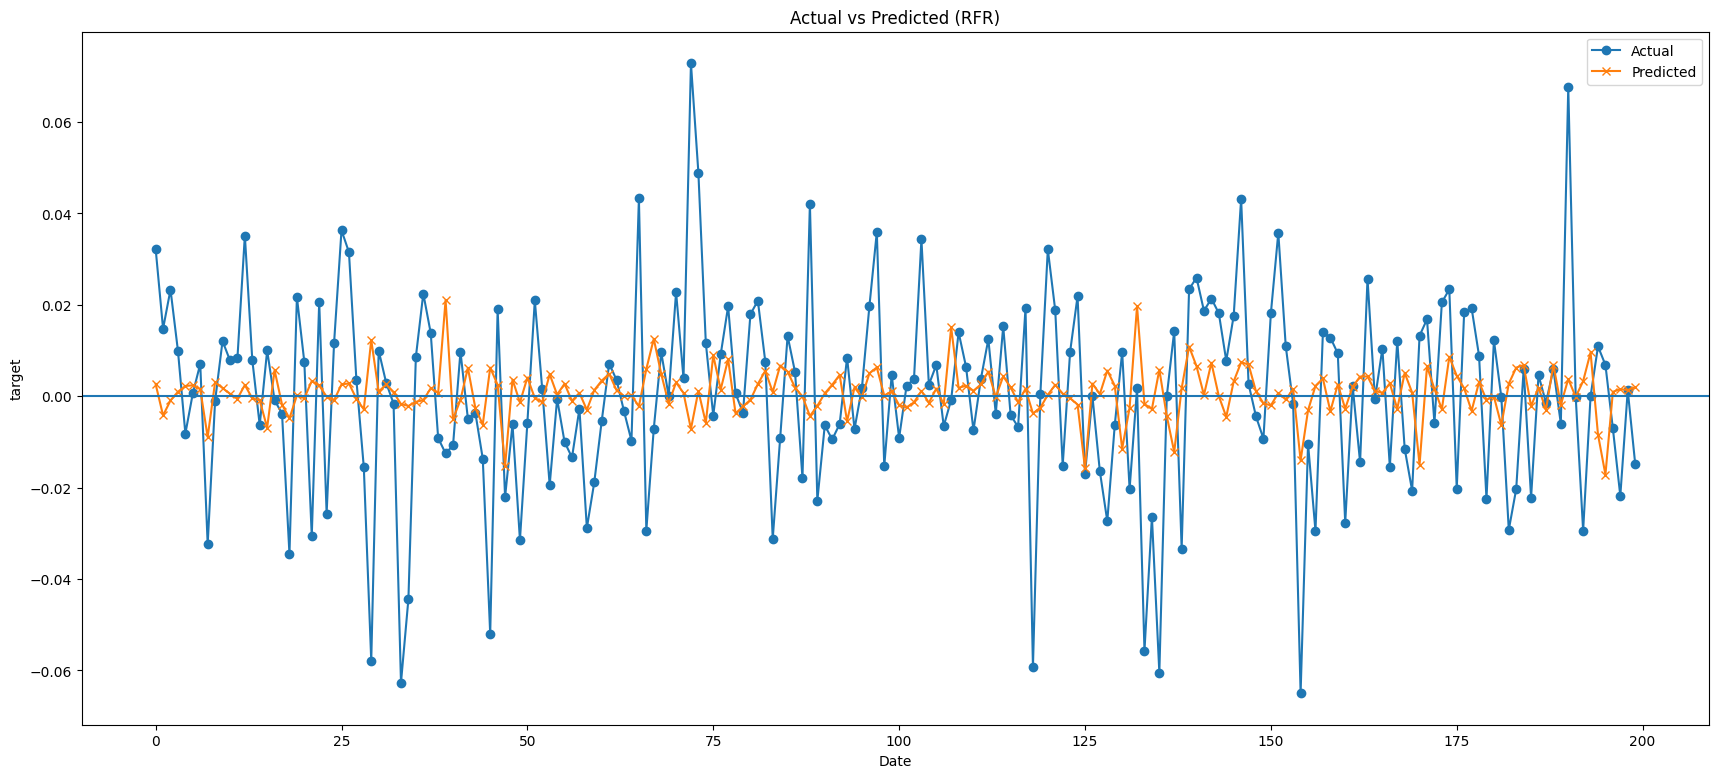

Model: XGB
MAE: 0.0161
MSE: 0.0005
RMSE: 0.0227
Direction: 0.5250


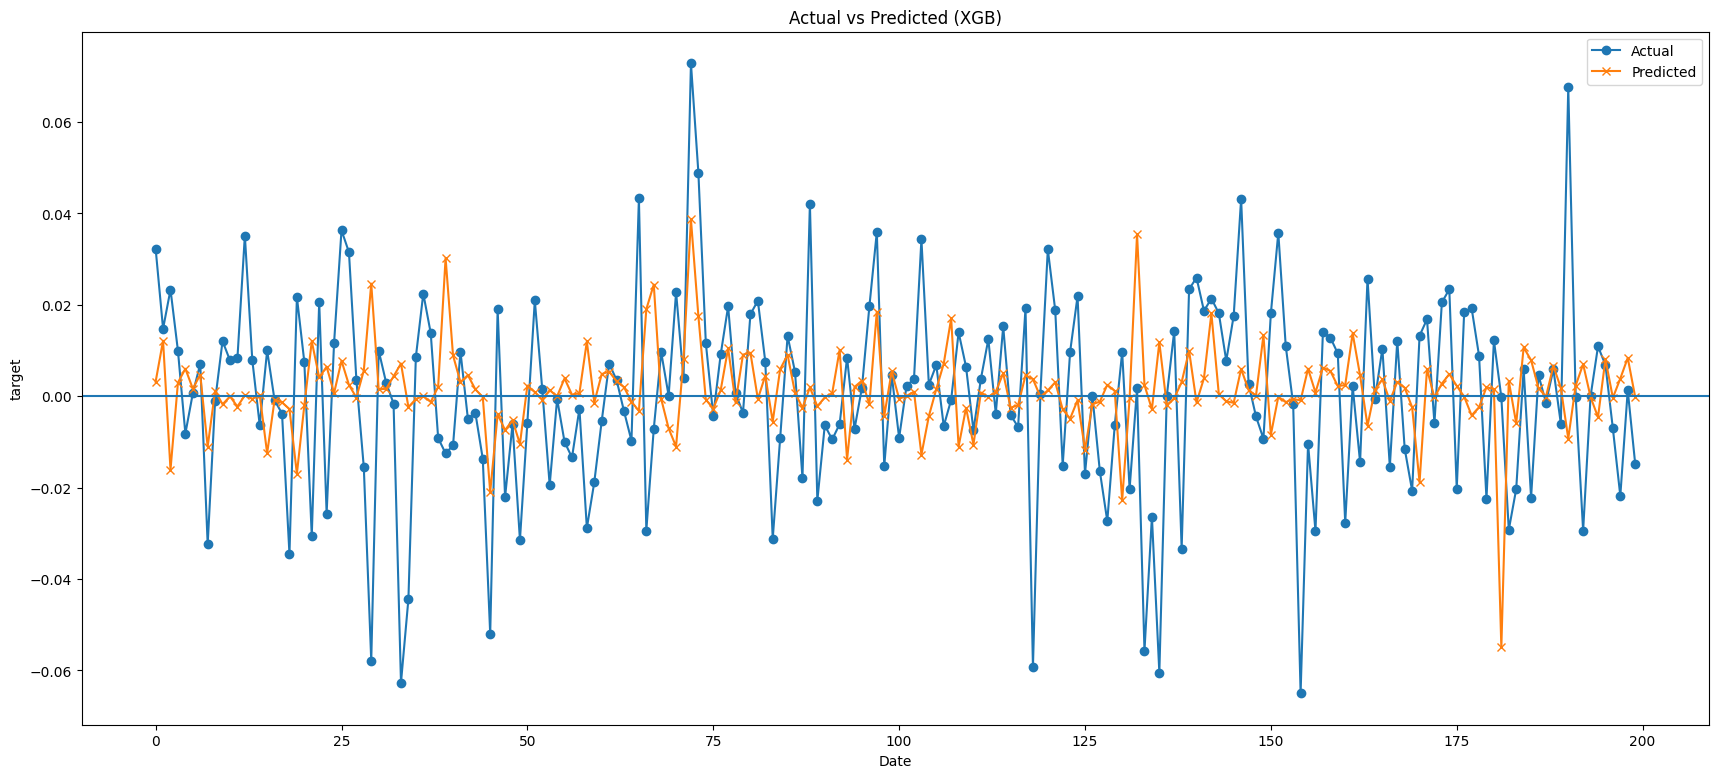

In [105]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"Direction: {metrics['direction']:.4f}")

    plt.figure(figsize=(21, 9))
    # plt.plot(range(len(y_test)), y_test, label='Actual', marker='o')
    # plt.plot(range(len(y_test)), metrics['y_pred_test'], label='Predicted', marker='x')

    n_data = 200
    plt.plot(range(n_data), y_test[:n_data], label='Actual', marker='o')
    plt.plot(range(n_data), metrics['y_pred_test'][:n_data], label='Predicted', marker='x')
    plt.axhline(y=0)

    plt.xlabel('Date')
    plt.ylabel('target')
    plt.title(f'Actual vs Predicted ({name})')
    plt.legend()
    plt.show()

# Hyper Parameter Tuning
**Strategy**: Grid Search CV

Exhaustive search over specified parameter values for an estimator.

inprogress ...

Use these manual tuning instead ↓

(They are just normal models but the train output is ten times larger than the real output. I found that somehow it prevents entire positive/negative prediction.)

In [109]:
manual_linear_model = LinearRegression()
manual_svr_model = SVR()
manual_rfr_model = RandomForestRegressor()
manual_xgb_model = xg.XGBRegressor()

manual_models = {
    'manual_LinearRegression': manual_linear_model,
    'manual_SVR': manual_svr_model,
    'manual_RFR': manual_rfr_model,
    'manual_XGB': manual_xgb_model
}

In [111]:
manual_results = dict()

for name, model in manual_models.items():
    print(f"Training {name} ...")

    model.fit(X_train, y_train * 10)
    y_pred_test = model.predict(X_test) / 10

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )

    # incase this model needs to be saved
    # joblib.dump(model, f"./models/tuned/{name}.sav")

    manual_results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training manual_LinearRegression ...
Training manual_SVR ...
Training manual_RFR ...
Training manual_XGB ...


Model: manual_LinearRegression
MAE: 0.0156
MSE: 0.0005
RMSE: 0.0220
Direction: 0.5227


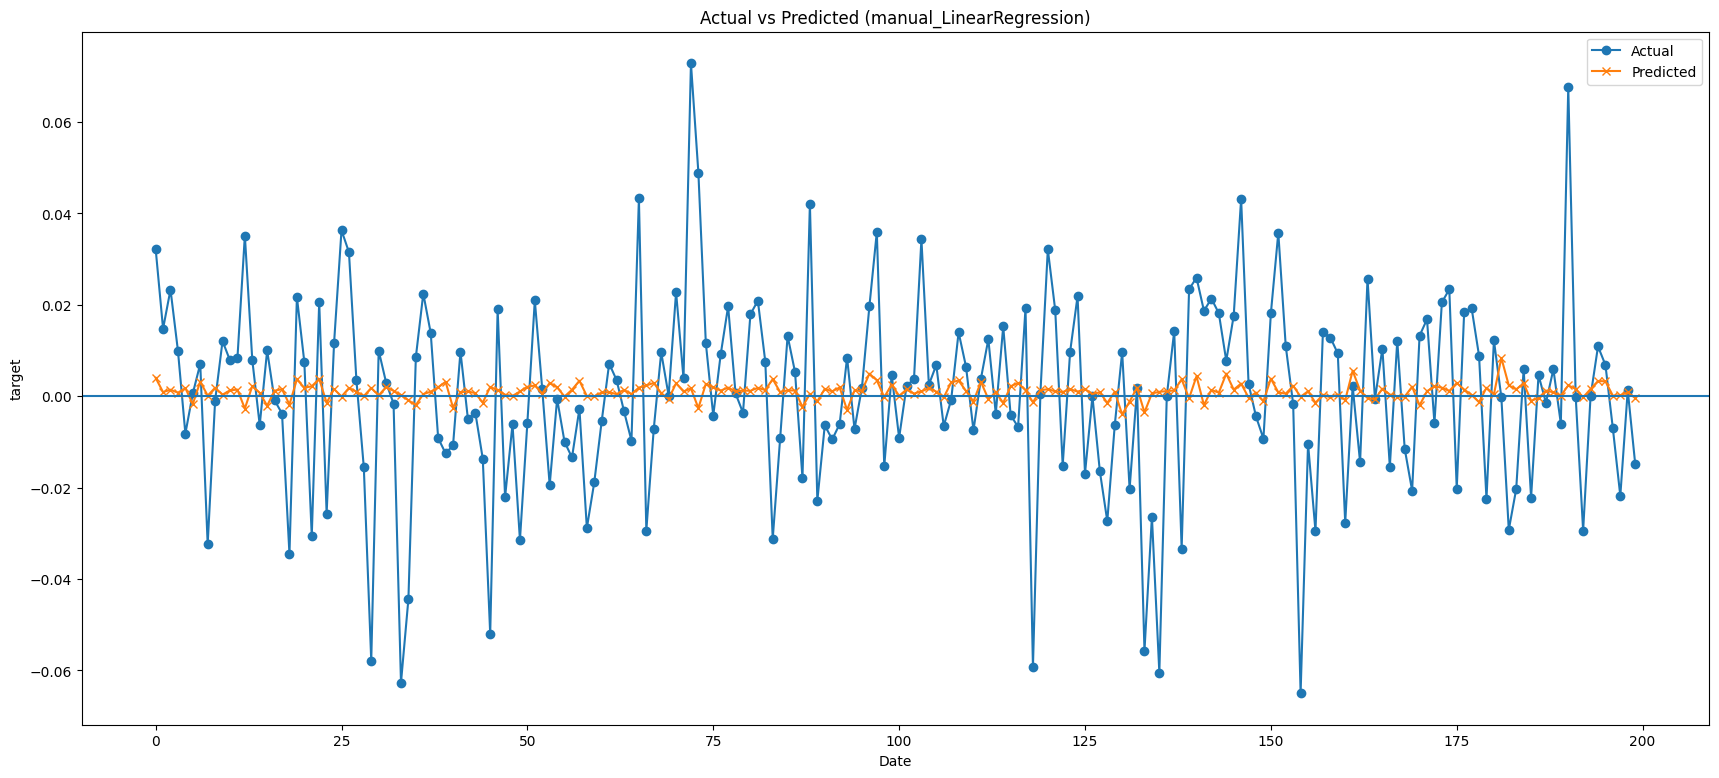

Model: manual_SVR
MAE: 0.0157
MSE: 0.0005
RMSE: 0.0221
Direction: 0.5388


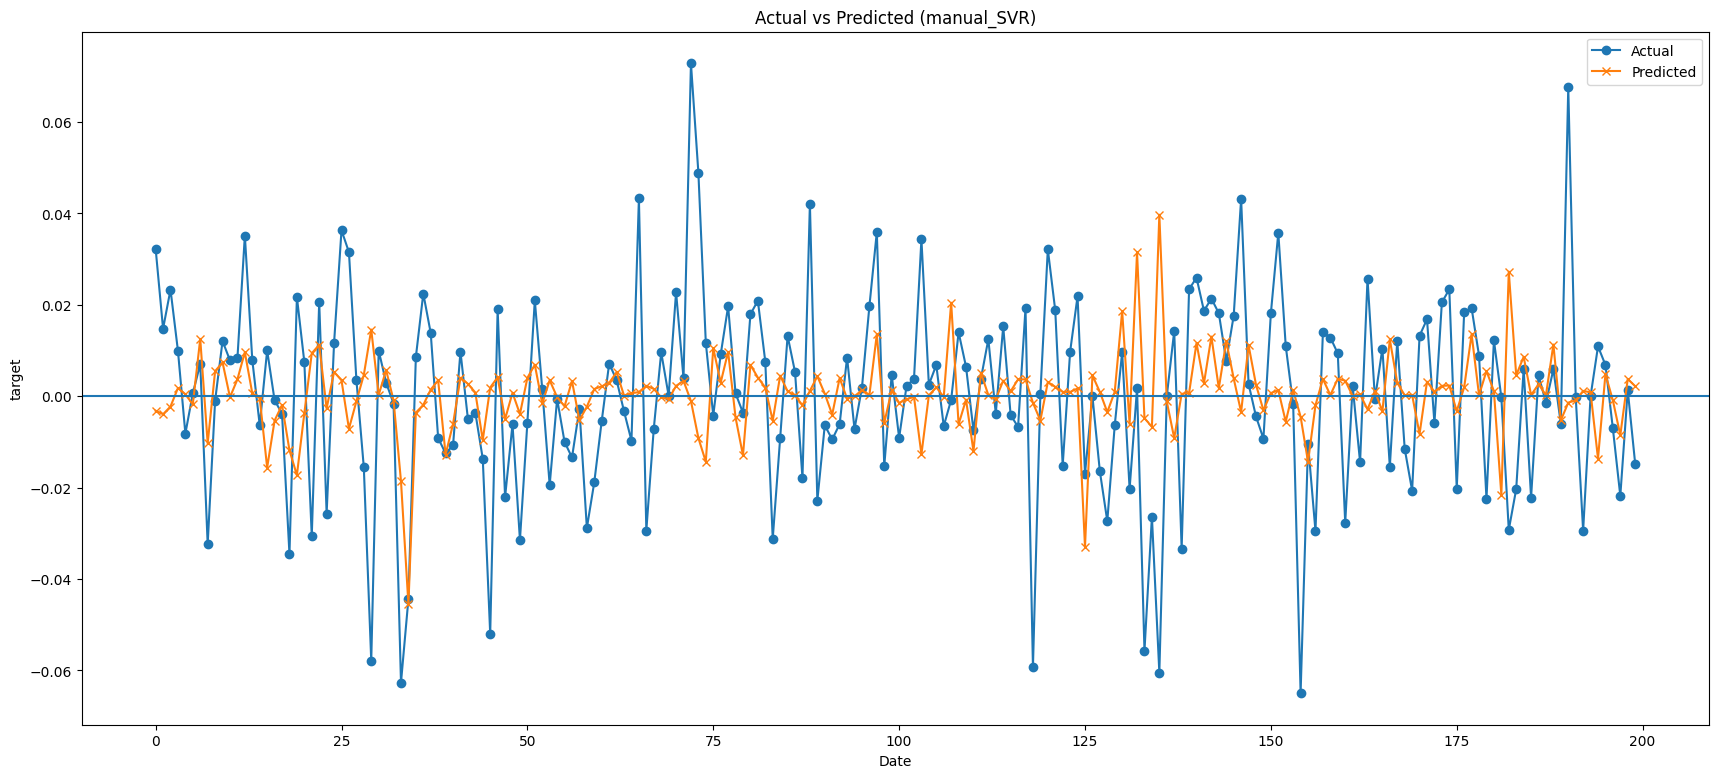

Model: manual_RFR
MAE: 0.0157
MSE: 0.0005
RMSE: 0.0220
Direction: 0.5313


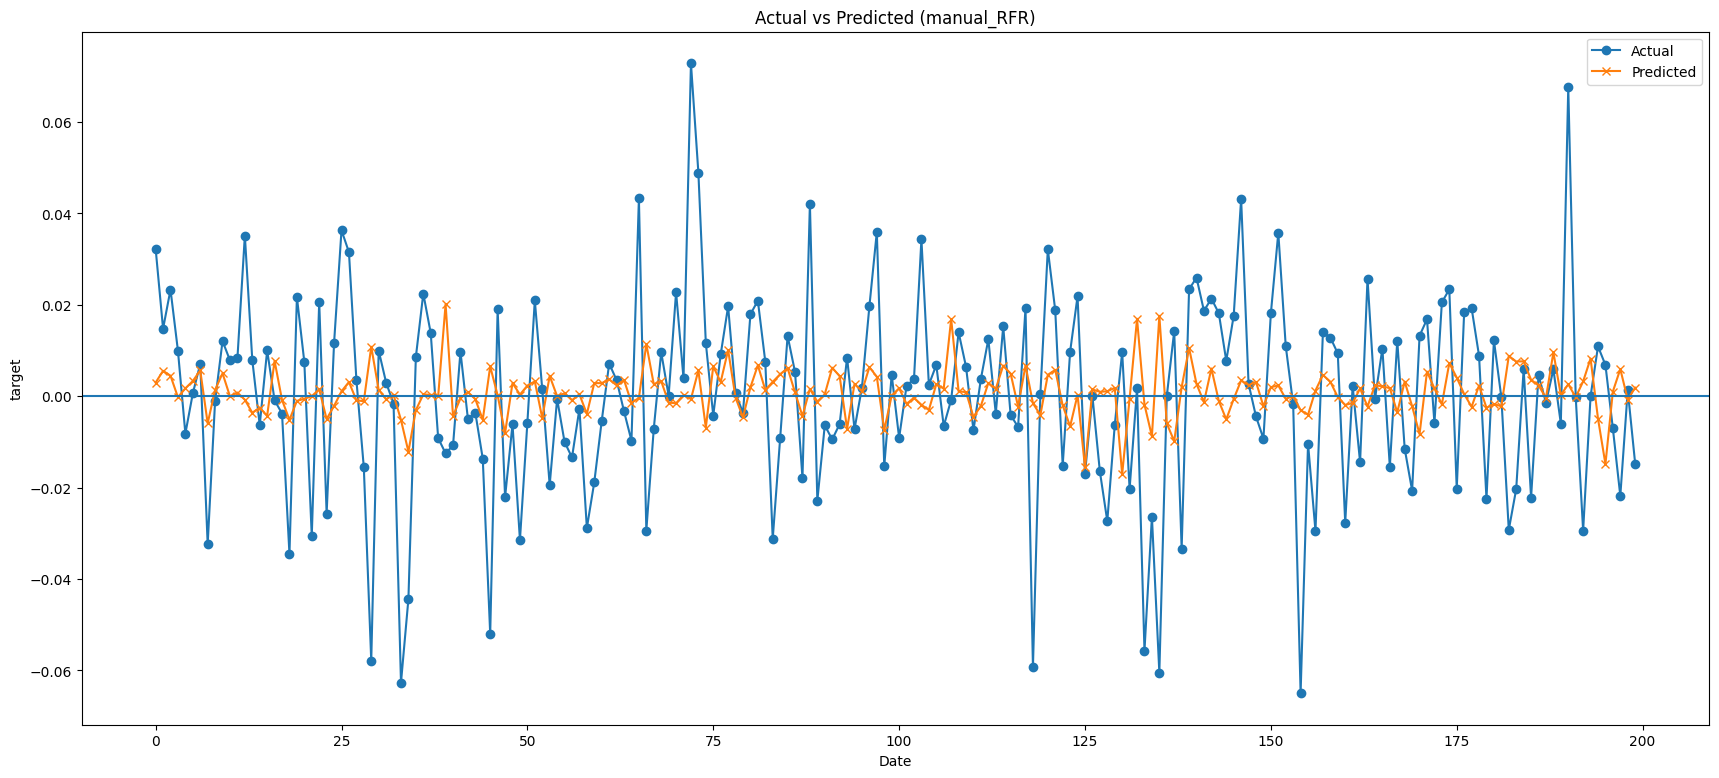

Model: manual_XGB
MAE: 0.0160
MSE: 0.0005
RMSE: 0.0227
Direction: 0.5329


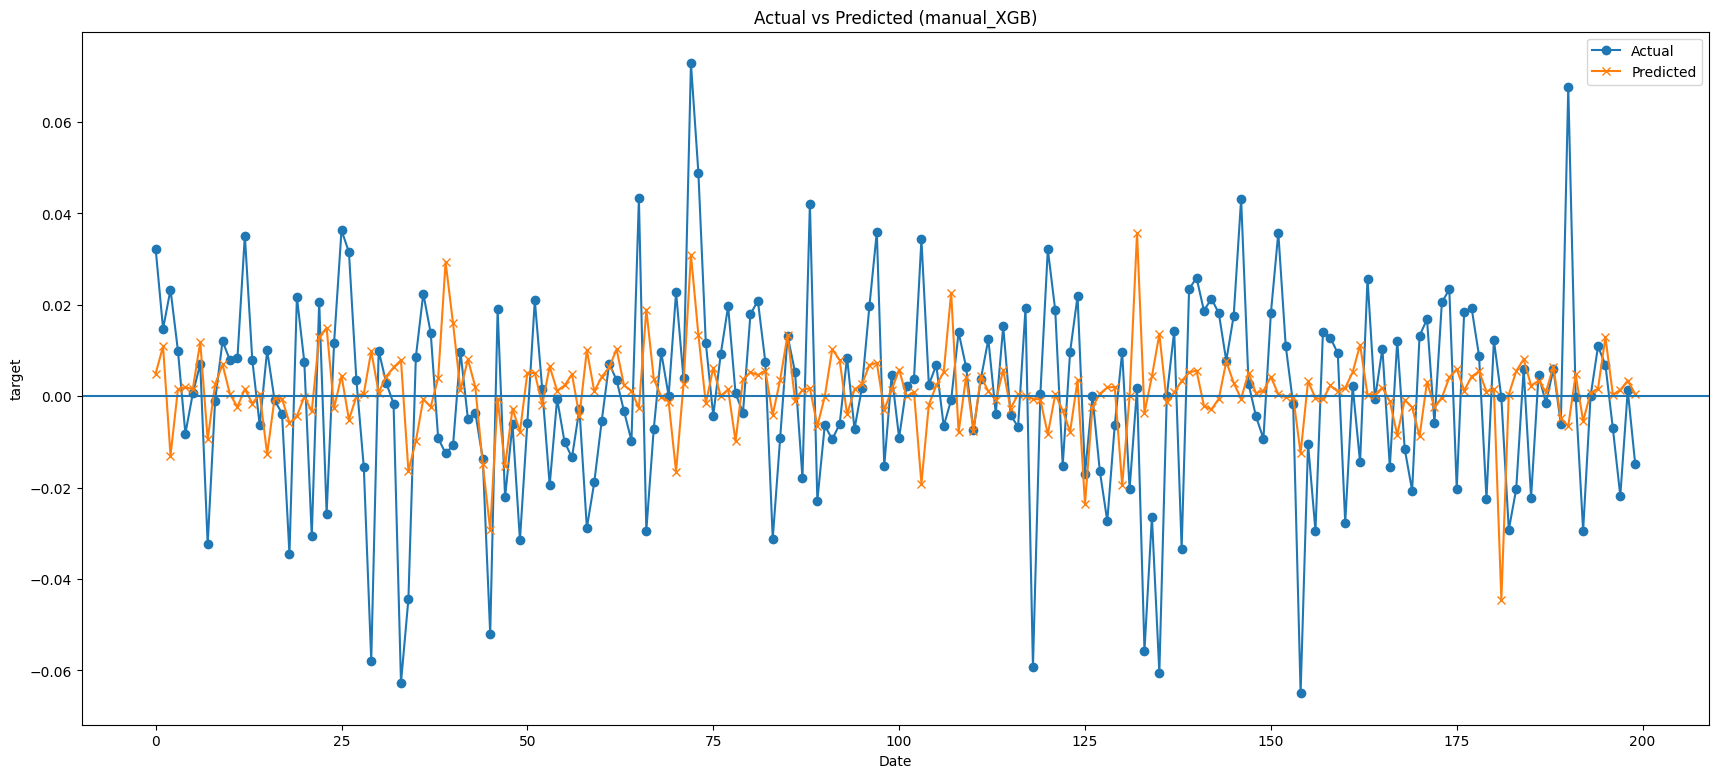

In [112]:
for name, metrics in manual_results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"Direction: {metrics['direction']:.4f}")

    plt.figure(figsize=(21, 9))
    # plt.plot(range(len(y_test)), y_test, label='Actual', marker='o')
    # plt.plot(range(len(y_test)), metrics['y_pred_test'], label='Predicted', marker='x')

    n_data = 200
    plt.plot(range(n_data), y_test[:n_data], label='Actual', marker='o')
    plt.plot(range(n_data), metrics['y_pred_test'][:n_data], label='Predicted', marker='x')
    plt.axhline(y=0)

    plt.xlabel('Date')
    plt.ylabel('target')
    plt.title(f'Actual vs Predicted ({name})')
    plt.legend()
    plt.show()

# Predicted Data

In [113]:
predict = dict()

for name, metrics in manual_results.items():
    print(f"Predicting {name} ...")
    y_pred = metrics['model'].predict(X)
    predict[name] = y_pred

predict_df = pd.DataFrame(predict)

Predicting manual_LinearRegression ...
Predicting manual_SVR ...
Predicting manual_RFR ...
Predicting manual_XGB ...


In [114]:
predict_df

,manual_LinearRegression,manual_SVR,manual_RFR,manual_XGB
0,0.002946,-0.008212,-0.005172,-0.039732
1,0.002114,-0.013859,-0.050530,-0.013862
2,-0.003890,-0.014272,-0.009335,0.031102
3,-0.000289,-0.009428,-0.011679,0.023524
4,-0.010085,0.001956,-0.054438,-0.011049
...,...,...,...,...
31159,0.001137,-0.061241,0.011724,-0.032215
31160,0.003256,-0.032228,-0.029818,-0.037114
31161,-0.001413,-0.022757,-0.029859,-0.046599
31162,0.003782,-0.068257,0.000280,-0.038924


# Trading

Strategy
- Position (Buy/Sell/do nothing) base on predicted '(log)return' of the next day
    - return > 0 : buy
    - return = 0 : do nothing
    - return < 0 : sell
- buy/sell all of portfolio in each transaction
- no short position

In [ ]:
df_trading = pd.DataFrame() # on test set
df_trading['^GSPC_log_return'] = y_test

for model_name in models:
    pred_log_return = results[model_name]['y_pred_test']
    position = ( pred_log_return > 0 ) # 1: Buy, 0: Sell
    model_log_return = position * df_trading['^GSPC_log_return']
    df_trading[model_name + '_log_return'] = model_log_return

df_trading

In [ ]:
df_trading.index = pd.to_datetime(df_trading.index)

total_days = (df_trading.index[-1] - df_trading.index[0]).days
years = total_days // 365
months = (total_days % 365) // 30

In [ ]:
buy_and_hold_total_return = np.exp(y_test.sum())

print(f'Total(Gross) Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {buy_and_hold_total_return *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {total_return *100:.2f}%')

print(f'\nNet Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1) *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1) *100:.2f}%')

print(f'\nNet Return (per year)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1)/total_days*365 *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1)/total_days*365 *100:.2f}%')